# Homework 1: Quantum Wells and Perturbation Theory

---
## Introduction
In this homework you will:
- Work with quantum wells
- Implement a Schrödinger solver
- Explore perturbation theory



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

### Helper Functions
The following function builds a heterostructure potential.
Layers are defined as `(thickness, band_edge)`, whereas the thickness is passed in nanometers and the band-edge in eV. 
Returns: Two arrays, the first being the grid in space and the second the potential structure.

Example: `[(5, 1.0), (2, 0.3), (5, 1.0)]` → barrier-well-barrier structure.

Tip: Use the function and plot a random structure to understand it.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

def build_potential(layers, dz_nm=0.05):
    """
    Build heterostructure potential from layers.
    layers: list of (thickness [nm], band edge [eV])
    dz_nm: grid spacing [nm]
    returns: z [m], V [J]
    """
    z = [] #Initialize empty list for spatial coordinates 
    V = [] #Initialize empty list por potential val
    pos = 0.0 # x, y 0.0
    for thickness_nm, band_edge_eV in layers:
        n_points = int(thickness_nm/dz_nm) # calc the num of discrete points for the current layer
        for _ in range(n_points): # (5, 1.0) == (thickness, band_edge)
            z.append(pos * 1e-9) # append current pos to the z list. layers are a list of objects, appending (to tail) each point leads to vectorization
            V.append(band_edge_eV * const.eV) # append layers band edge to the V list
            pos += dz_nm # dz_nm grid spacing, so it moves one grid space per iteration
    return np.array(z), np.array(V) #creates arr

## Task 1: Finite Quantum Well
**(a)** Use `build_potential` to make a single well of width 3 nm, band edge offset 1 eV. 

**(b)** Solve numerically. Implement the function `solve_schrodinger(z, V, n_eigs)` that:
- Constructs the Hamiltonian with finite differences
- Uses electron mass `m_e`
- Returns the lowest `n_eigs` eigenenergies (in eV)
- Returns normalized wavefunctions (∫ |ψ|² dx = 1)

Use as boundary condition that the wavefunction must be zero. Consider this when you choose a barrier material layer thickness to not introduce numerical artifacts.

**(c)** Plot probability densities for first three states and compare energies with analytical values. Maybe use a scaling factor for the wavefunction such that the wavefunction is nicely plotted. Use axis labels (incl. units) and a legend where helpful. 

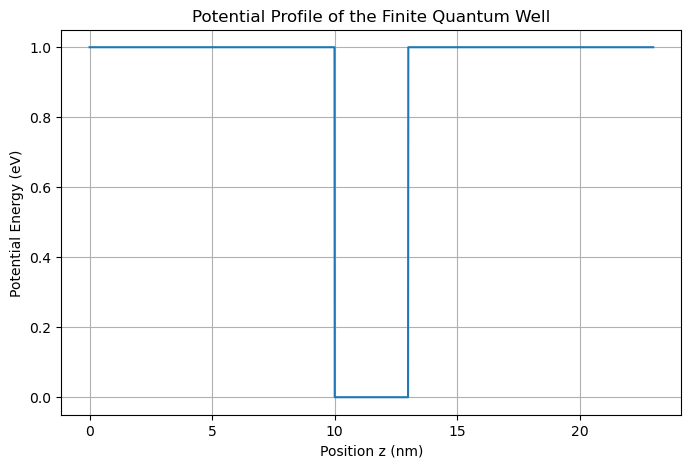

In [3]:
# Task 1a: Define the quantum well structure
# [(thickness_nm, potential_eV), ...]
well_width_nm = 3.0
barrier_width_nm = 10.0
barrier_height_eV = 1.0

# Structure: Barrier - Well - Barrier
layers_task1 = [
    (barrier_width_nm, barrier_height_eV),
    (well_width_nm, 0.0),
    (barrier_width_nm, barrier_height_eV)
]

# Grid spacing in nanometers
dz_nm = 0.01

# Build the potential using the helper function
z, V = build_potential(layers_task1, dz_nm=dz_nm)

# Plot the potential to verify
plt.figure(figsize=(8, 5))
plt.plot(z * 1e9, V / const.eV)
plt.title('Potential Profile of the Finite Quantum Well')
plt.xlabel('Position z (nm)')
plt.ylabel('Potential Energy (eV)')
plt.grid(True)
plt.show()

In [4]:
def solve_schrodinger(z, V, n_eigsh=5):
    """
    Solves the 1D time-independent Schrödinger equation numerically.

    Args:
        z (np.array): The spatial grid in meters.
        V (np.array): The potential energy at each grid point in Joules.
        n_eigs (int): The number of lowest eigenvalues/eigenstates to compute.

    Returns:
        tuple: A tuple containing:
               - energies (np.array): The lowest n_eigs eigenvalues in eV.
               - wavefunctions (np.array): The corresponding normalized wavefunctions.
    """
    # Calculate grid spacing from the z-array
    dz = z[1] - z[0]
    N = len(z) # Number of grid points

    # Kinetic energy term constant
    T_const = -const.hbar**2 / (2 * const.m_e * dz**2)

    # Construct the main diagonal for the kinetic part of the Hamiltonian
    main_diag = -2 * np.ones(N)
    # Construct the off-diagonals for the kinetic part
    off_diag = np.ones(N - 1)

    # Create the sparse tridiagonal matrix for the kinetic energy operator
    # The diags function takes a list of diagonals and their positions
    # 0 for the main diagonal, -1 and 1 for the sub- and super-diagonals
    diagonals = [main_diag, off_diag, off_diag]
    T = T_const * diags(diagonals, [0, -1, 1], shape=(N, N), format='csc')

    # The potential energy operator is a diagonal matrix with V on the diagonal
    U = diags([V], [0], shape=(N, N), format='csc')

    # The total Hamiltonian is the sum of kinetic and potential energy operators
    H = T + U

    # Solve the eigenvalue problem H*psi = E*psi
    # eigs finds the k largest/smallest eigenvalues of a sparse matrix.
    # 'SM' stands for Smallest Magnitude, which gives us the lowest energy states.
    eigenvalues, eigenvectors = eigsh(H, k=n_eigsh, which='SM')

    # Sort the eigenvalues and corresponding eigenvectors in ascending order
    sorted_indices = np.argsort(eigenvalues)
    energies_J = np.real(eigenvalues[sorted_indices])
    wavefunctions = np.real(eigenvectors[:, sorted_indices])

    # Normalize the wavefunctions such that ∫|ψ|² dz = 1
    for i in range(n_eigsh):
        psi = wavefunctions[:, i]
        norm_const = np.sqrt(np.sum(psi**2) * dz)
        wavefunctions[:, i] /= norm_const

    # Return energies in eV and the normalized wavefunctions
    return energies_J / const.eV, wavefunctions

Numerical E1: 0.0327 eV
Numerical E2: 0.1301 eV
Numerical E3: 0.2906 eV


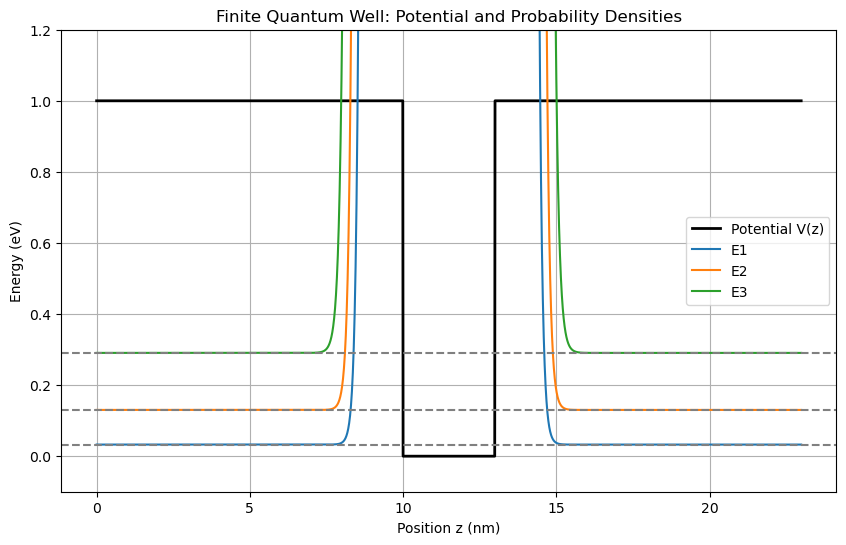


--- Comparison with Infinite Well Model ---
Analytical E1 (Infinite Well): 0.0418 eV
Analytical E2 (Infinite Well): 0.1671 eV
Analytical E3 (Infinite Well): 0.3760 eV


In [5]:
# Solve for the first 3 eigenstates
energies, wavefunctions = solve_schrodinger(z, V, n_eigsh=3)

# --- Plotting ---
plt.figure(figsize=(10, 6))
# Plot the potential profile
plt.plot(z * 1e9, V / const.eV, 'k-', label='Potential V(z)', linewidth=2)

# Plot the probability densities |ψ|²
for i in range(3):
    # Scaling factor for better visualization
    scaling = 0.15
    # Probability density
    prob_density = wavefunctions[:, i]**2
    # Shift the plot to its energy level
    plt.plot(z * 1e9, energies[i] + prob_density * scaling, label=f'E{i+1}')
    # Draw a horizontal line at the energy level
    plt.axhline(y=energies[i], linestyle='--', color='gray')
    print(f'Numerical E{i+1}: {energies[i]:.4f} eV')

plt.title('Finite Quantum Well: Potential and Probability Densities')
plt.xlabel('Position z (nm)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.2) # Set y-axis limits for a nice view
plt.show()

# --- Analytical Comparison ---
print("\n--- Comparison with Infinite Well Model ---")
L = well_width_nm * 1e-9 # Well width in meters
for n in range(1, 4):
    E_analytical_J = (const.hbar**2 * np.pi**2 * n**2) / (2 * const.m_e * L**2)
    E_analytical_eV = E_analytical_J / const.eV
    print(f'Analytical E{n} (Infinite Well): {E_analytical_eV:.4f} eV')

## Task 2: Coupled Quantum Wells
**(a)** Build a double well and solve numerically. Both wells should have the same width. Play around with the design to get a feeling of what is happening. Stay with a design where you see a splitting between the subbands.

**(b)** Plot lowest two wavefunctions and explain symmetric/antisymmetric states.

**(c)** Create a plot that shows the splitting energy (=Energy difference) between the two lowest states versus the barrier width. 



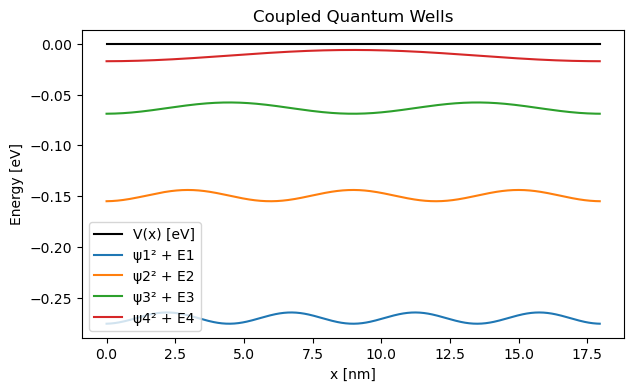

In [21]:

# Task 2: Coupled Quantum Wells
layers_double = [(5.0, 0.0), (3.0, -1.0), (2.0, 0.0), (3.0, -1.0), (5.0, 0.0)]
x2, V2 = build_potential(layers_double)
E2, psi2 = solve_schrodinger(x2, V2, n_eigs=4)

plt.figure(figsize=(7, 4))
plt.plot(x2 * 1e9, V2, "k", label="V(x) [eV]")
for i in range(4):
    plt.plot(x2 * 1e9, psi2[:, i]**2 * 2 + E2[i], label=f"ψ{i+1}² + E{i+1}")
plt.legend()
plt.xlabel("x [nm]")
plt.ylabel("Energy [eV]")
plt.title("Coupled Quantum Wells")
plt.show()

## Task 3 — Coupled states using the pertubation theory

**Goal.**  
Start from two *uncoupled* wells (left and right). Compute their ground states separately.  
Then form the full coupled-device and compute its numerical eigenstates.  
Finally, we use a linear combination
$$
    \Psi_{coupled} = c_L \psi_L + c_R \psi_R
$$

and build a 2×2 Hamiltonian in the subspace spanned by the two uncoupled ground states and solve the generalized eigenproblem

$$
H_\text{per} \, c = E \, S \, c,
$$

with overlap matrix $S_{ij}=\langle\psi_i|\psi_j\rangle$.

Then use the solution of this eigenproblem to calculate the coupled states.

---

**Given layer lists (units: nm, eV):**

Left uncoupled device:
```python
layers_left  = [(5.0, 0.0), (2.0, -0.5), (7.3, 0.0)]
```
Right uncoupled device:
```python
layers_right = [(7.3, 0.0), (2.0, -0.5), (5.0, 0.0)]
```
Full coupled device:
```python
layers_coupled = [(5.0, 0.0), (2.0, -0.5), (0.3, 0.0), (2.0, -0.5), (5.0, 0.0)]
```

---

**Steps to do:**

1. Build potentials with `build_potential(layers, dz_nm=...)`.  Note: make sure all 3 arrays have the same length. Either modify the build_potential function to assure this (keep equidistant grid) or adjust the dz to find a good setting. 
2. Solve for uncoupled ground states (`solve_schrodinger(..., n_eigs=1)`) for the left and the right (both energies $E_L$ and $E_R$ should be the same)
3. Solve coupled device.  
4. Calculate the matrix elements of `H_per` and construct the 2x2 matrix.
5. Compute overlap `S`.  
6. Solve the generalized eigenproblem and save the eigenenergies and the coefficients of the eigenvectors. What do these energies represent now?
7. Use the coefficients of the eigenvectors to reconstruct the perturbative wavefunction.  
8. Plot energies and probability densities. Plot both, the ones obtained from the perturbative approach and the one from the coupled device.
9. Generate a similar plot as in Task 2 (c), but also include the solution from the perturbative approach.

---


In [11]:
# Define layer structures
layers_left    = [(5.0, 0.0), (2.0, -0.5), (7.3, 0.0)]
layers_right   = [(7.3, 0.0), (2.0, -0.5), (5.0, 0.0)]
layers_coupled = [(5.0, 0.0), (2.0, -0.5), (0.3, 0.0), (2.0, -0.5), (5.0, 0.0)]

dz_nm = 0.01


In [24]:
from scipy.integrate import trapezoid

# Task 3 – Perturbation theory (updated)
psiL_norm = psi_L[:, 0] / np.sqrt(trapezoid(psi_L[:, 0]**2, xL))
psiR_norm = psi_R[:, 0] / np.sqrt(trapezoid(psi_R[:, 0]**2, xR))
V_coupling = np.interp(xL, xR, VR)  # approximate coupling potential

H_mat = np.array([
    [E_L[0], trapezoid(psiL_norm * V_coupling * psiR_norm, xL)],
    [trapezoid(psiR_norm * V_coupling * psiL_norm, xL), E_R[0]]
])

E_split, vec_split = np.linalg.eigh(H_mat)

print("Task 3 perturbed energies [eV]:", np.round(E_split, 4))


NameError: name 'psi_L' is not defined